### SET UP

In [23]:
# Cài Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Tải và giải nén Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz

# Cài findspark
!pip install -q findspark

# Thiết lập biến môi trường cho JAVA và SPARK
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Khởi tạo findspark
import findspark
findspark.init()

# Import SparkSession và khởi tạo
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OnlineRestore") \
    .master("local[*]") \
    .getOrCreate()

# Kiểm tra phiên bản Spark
print("Spark version:", spark.version)


Spark version: 3.3.2


In [24]:
from google.colab import files
file= files.upload()

Saving OnlineRetail.csv to OnlineRetail (1).csv


### 2. Load data

In [25]:
df = spark.read.csv("OnlineRetail.csv", header=True, inferSchema=True)
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



#### 3. Data Profiling, Anomaly Detection and Data Cleaning

##### 3.1 Check the number of colummns and rows

In [28]:
# Check the number of columns and rows
print("Number of columns: ", len(df.columns))
print("Number of rows: ", df.count())

Number of columns:  8
Number of rows:  541909


##### 3.2 Abnormal 1: Check and correct Data Type

In [29]:
# Check schema
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [30]:
# Convert datatype of InvoiceDate to timestamp
df_cleaned = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))

# Re-check schema
df_cleaned.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### 3.3 Abnormal 2: Check and handle missing values

In [31]:
# Check for missing values in original data
missing_values = df_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])
missing_values.show()


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



- Description: 1,454 --> remove since it is hard to guess the product description
- CustomerID: 135,080 --> might keep them, change null value into Unknown

In [32]:
# Delete the null values in Description
df_cleaned = df_cleaned.filter(df_cleaned.Description.isNotNull())

# Change the value in CustomerID into "Unknown" for null values
df_cleaned = df_cleaned.withColumn("CustomerID", when(df_cleaned.CustomerID.isNull(), "Unknown").otherwise(df_cleaned.CustomerID))

In [33]:
# Re-check for missing values in the cleaned data
missing_values = df_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])
missing_values.show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



### 3.4 Abnormal 3: Check and handle duplicate rows

In [34]:
# Check the number of duplicate rows
duplicate_count = df_cleaned.count() - df_cleaned.dropDuplicates().count()
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  5268


In [35]:
# Drop duplicate rows
df_cleaned = df_cleaned.dropDuplicates()

In [36]:
# Re-check the number of duplicate rows
duplicate_count = df_cleaned.count() - df_cleaned.dropDuplicates().count()
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  0


### 3.5 Abnormal 4: Handle negative Quantity and UnitPrice

### Check the number of cancelled order: The InvoiceNo starts with C (has negative Quantity)

In [37]:
cancel = df_cleaned.filter(col("InvoiceNo").startswith("C"))
print("Number of canceled orders: ", cancel.count())
cancel.show(5)

Number of canceled orders:  9251
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  C536606|    20914|SET/5 RED RETROSP...|      -2|2010-12-02 09:10:00|     2.95|     14092|United Kingdom|
|  C537998|    22727|ALARM CLOCK BAKEL...|      -4|2010-12-09 11:42:00|     3.75|     17411|United Kingdom|
|  C538723|    22333|RETROSPOT PARTY B...|      -7|2010-12-14 11:12:00|     1.65|     12434|     Australia|
|  C538763|    22107|  PIZZA PLATE IN BOX|      -8|2010-12-14 11:33:00|     3.75|     17722|United Kingdom|
|  C539278|    22617|BAKING SET SPACEB...|      -6|2010-12-16 15:39:00|     4.95|     18269|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+-----------

### Check for invalid values in Quantity and UnitPrice:

- Quantity < 0
- UnitPrice < 0

In [38]:
# Quantity has negative value
negative_Quantity = df_cleaned.filter(col("Quantity") < 0).count()
print("Number of negative Quantity: ", negative_Quantity)
df_cleaned.filter(col("Quantity") < 0).select("InvoiceNo", "Quantity").show(5)

Number of negative Quantity:  9725
+---------+--------+
|InvoiceNo|Quantity|
+---------+--------+
|  C536606|      -2|
|  C537998|      -4|
|  C538723|      -7|
|  C538763|      -8|
|  C539278|      -6|
+---------+--------+
only showing top 5 rows



In [39]:
# UnitPrice has negative value
negative_UnitPrice = df_cleaned.filter(col("UnitPrice") < 0).count()
print("Number of negative UnitPrice: ", negative_UnitPrice)
df_cleaned.filter(col("UnitPrice") < 0).select("InvoiceNo", "UnitPrice").show(5)

Number of negative UnitPrice:  2
+---------+---------+
|InvoiceNo|UnitPrice|
+---------+---------+
|  A563187|-11062.06|
|  A563186|-11062.06|
+---------+---------+



- We can see that cancelled orders also have the negative Quantity.
- The dataset contains 9,251 cancelled orders, while 9,725 orders have a negative quantity.
- Therefore, in the Data Cleaning section, when we remove orders with negative quantities, we also remove the cancelled orders at the same time.

### Remove abnormal Quantity and UnitPrice

In [40]:
# Filter out negative Quantity and UnitPrice
df_cleaned = df_cleaned.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# Check negative Quantity and UnitPrice again
print("Negative Quantity count:", df_cleaned.filter(col("Quantity") < 0).count())
print("Negative UnitPrice count:", df_cleaned.filter(col("UnitPrice") < 0).count())

# Check number of cancelled orders again
cancel = df_cleaned.filter(col("InvoiceNo").startswith("C"))
print("Number of cancelled orders: ", cancel.count())

Negative Quantity count: 0
Negative UnitPrice count: 0
Number of cancelled orders:  0


### 3.6 Abnormal 5: Identify abnormal StockCode-Description pairs that are not actual products
- Check abnormal StockCode

In [41]:
excluded_stockcodes = ["POST", "DOT", "M", "C2", "BANK CHARGES","S", "B", "AMAZONFEE",
                       "gift_0001_10", "gift_0001_20","gift_0001_30","gift_0001_40","gift_0001_50"]

# Identify rows with exclued StockCode
df_excluded = df_cleaned.filter(col("StockCode").isin(excluded_stockcodes))

# Show distinct excluded StockCode - Description pairs
df_excluded.select("StockCode", "Description").distinct().show(truncate=False)

+------------+----------------------------------+
|StockCode   |Description                       |
+------------+----------------------------------+
|POST        |POSTAGE                           |
|DOT         |DOTCOM POSTAGE                    |
|gift_0001_40|Dotcomgiftshop Gift Voucher �40.00|
|C2          |CARRIAGE                          |
|gift_0001_30|Dotcomgiftshop Gift Voucher �30.00|
|BANK CHARGES|Bank Charges                      |
|M           |Manual                            |
|AMAZONFEE   |AMAZON FEE                        |
|gift_0001_50|Dotcomgiftshop Gift Voucher �50.00|
|gift_0001_20|Dotcomgiftshop Gift Voucher �20.00|
|S           |SAMPLES                           |
|gift_0001_10|Dotcomgiftshop Gift Voucher �10.00|
|B           |Adjust bad debt                   |
+------------+----------------------------------+



### Handle abnormal StockCode and Description pairs that are not actual products

In [42]:
df_cleaned = df_cleaned.filter(~col("StockCode").isin(excluded_stockcodes))

In [43]:
# Re-check the abnormal stock code
df_excluded = df_cleaned.filter(col("StockCode").isin(excluded_stockcodes))
df_excluded.select("StockCode", "Description").distinct().show(truncate=False)

+---------+-----------+
|StockCode|Description|
+---------+-----------+
+---------+-----------+



### 4. Data cleaning results

In [44]:
# The number of rows before cleaning
rows_before_cleaning = df.count()
print(f"Number of rows before cleaning: {rows_before_cleaning}")

Number of rows before cleaning: 541909


In [45]:
# Check the number of rows after cleaning
rows_after_cleaning = df_cleaned.count()
print(f"Number of rows after cleaning: {rows_after_cleaning}")

Number of rows after cleaning: 522541


### 5. Feature Engineering

In [46]:
# Convert InvoiceDate data type to DateType
df_fe = df_cleaned.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "M/d/yyyy H:mm"))
df_fe.printSchema()
df_fe.show(5)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536415|    22951|60 CAKE CASES DOL...|       2| 2010-12-01|     0.55|     12838|United Kingdom|
|   536488|    22909|SET OF 20 VINTAGE...|       1| 2010-12-01|     0.85|     17897|United Kingdom|
|   536592|    22665|RECIPE BOX BLUE S...|       1| 2010-12-01|     5.91|   Unknown|United Kingdom|
|   536600|   84029G|KNITTED UNION FLA...|       6| 2010-12-02|  

In [47]:
# Get the max date of the dataset
max_date = df_fe.agg(max("InvoiceDate")).collect()[0][0]
max_date

datetime.date(2011, 12, 9)

In [48]:
# Calculate recency
recency_df = df_fe.groupBy("CustomerID").agg(
    datediff(lit(max_date), max("InvoiceDate")).alias("Recency")
)
recency_df.show(5)


+----------+-------+
|CustomerID|Recency|
+----------+-------+
|     16250|    261|
|     15574|    177|
|     15555|     12|
|     15271|      7|
|     17714|    320|
+----------+-------+
only showing top 5 rows



In [53]:
# Calculate frequency (number of transactions per customer)
frequency_df = df_fe.groupBy("CustomerID").agg(
    count("InvoiceNo").alias("Frequency")
)
frequency_df.show(5)

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     13610|      215|
|     15555|      885|
|     15271|      264|
|     15574|      152|
|     13282|       37|
+----------+---------+
only showing top 5 rows



In [54]:
# Calculate Monetary (Total money spent by customer)
monetary_df = df_fe.withColumn("TotalPrice", col("Quantity") * col("UnitPrice")) \
    .groupBy("CustomerID") \
    .agg(round(sum("TotalPrice"), 3).alias("Monetary"))
monetary_df.show(5)

+----------+--------+
|CustomerID|Monetary|
+----------+--------+
|     13610| 1082.33|
|     15555| 4791.87|
|     15271| 2493.34|
|     15574|  675.64|
|     13282| 1132.14|
+----------+--------+
only showing top 5 rows



In [55]:
# Join all RFM features
dfs = [recency_df, frequency_df, monetary_df]
rfm_df = reduce(lambda df1, df2: df1.join(df2, "CustomerID"), dfs)
rfm_df.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     13610|     12|      215| 1082.33|
|     15555|     12|      885| 4791.87|
|     15271|      7|      264| 2493.34|
|     15574|    177|      152|  675.64|
|     13282|     18|       37| 1132.14|
+----------+-------+---------+--------+
only showing top 5 rows



In [52]:
# Calculate the average of Recency, Frequency, and Monetary
rfm_df.select(
    mean("Recency").alias("Mean_Recency"),
    mean("Frequency").alias("Mean_Frequency"),
    mean("Monetary").alias("Mean_Monetary")
).show()

+-----------------+------------------+------------------+
|     Mean_Recency|    Mean_Frequency|     Mean_Monetary|
+-----------------+------------------+------------------+
|92.20530565167243|120.54002306805074|2363.8343420991937|
+-----------------+------------------+------------------+



In [56]:
# Define thresholds based on the mean values
recency_threshold = 95
frequency_threshold = 120

# Create a new column 'Churn' based on the thresholds
rfm_df = rfm_df.withColumn(
    "Churn",
    when((col("Recency") > recency_threshold) & (col("Frequency") <= frequency_threshold), 1).otherwise(0)
)

# Show the resulting DataFrame with Churn column
rfm_df.select("CustomerID", "Recency", "Frequency", "Monetary", "Churn").show()

+----------+-------+---------+--------+-----+
|CustomerID|Recency|Frequency|Monetary|Churn|
+----------+-------+---------+--------+-----+
|     13610|     12|      215| 1082.33|    0|
|     15555|     12|      885| 4791.87|    0|
|     15271|      7|      264| 2493.34|    0|
|     15574|    177|      152|  675.64|    0|
|     13282|     18|       37| 1132.14|    0|
|     14157|     19|       46|  424.89|    0|
|     16250|    261|       24|  389.44|    1|
|     12394|     63|       25| 1080.48|    0|
|     17686|      7|      286| 5739.46|    0|
|     16320|    172|       56| 1038.46|    1|
|     13865|     58|       30|  501.56|    0|
|     13772|     33|      173| 1122.63|    0|
|     17714|    320|       10|   153.0|    1|
|     13192|     95|       63|  911.94|    0|
|     18130|     15|       70| 1059.39|    0|
|     16504|     25|       83|  465.88|    0|
|     17506|     75|       14|   302.2|    0|
|     12847|     22|       84|  843.64|    0|
|     14887|     79|        6|  18

### Final Dataframe

- If you want to work with timestamp (yyyy-M-d H:mm:ss) data, please use the code: [df_cleaned.join()]
- If you want to work with date (only yyyy=M-d), please change the below code:[df_cleaned.join()] --> [df_fe.join()]

In [58]:
# Join churn label into transaction-level cleaned data
final_df = rfm_df.join(df_cleaned, on="CustomerID", how="left")
final_df.show()

+----------+-------+---------+--------+-----+---------+---------+--------------------+--------+-------------------+---------+-------+
|CustomerID|Recency|Frequency|Monetary|Churn|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|Country|
+----------+-------+---------+--------+-----+---------+---------+--------------------+--------+-------------------+---------+-------+
|     12394|     63|       25| 1080.48|    0|   552188|    22557|PLASTERS IN TIN V...|      12|2011-05-06 14:01:00|     1.65|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    22551|PLASTERS IN TIN S...|      12|2011-05-06 14:01:00|     1.65|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    21244|BLUE POLKADOT PLATE |       8|2011-05-06 14:01:00|     1.69|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    23256|CHILDRENS CUTLERY...|       8|2011-05-06 14:01:00|     4.15|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    212

- For further steps after my parts, I got a few instruction for each role of the type of dataframe

- df: original raw dataframe
- df_cleaned: dataframe after data cleaning in part 3
- df_fe : dataframe where the InvoiceDate converted into Date formula.
- rfm_df : The RFM dataframe with columns [CustomerID, Recency, Frequency, Monetary, Churn]
- final_df (optional) : use this if you prefer working directly with the cleaned transactional data (df_cleaned) rather than the aggregated RFM data.

### Analysis Of Online Retail
- I used final_df with final_df is the rfm_df join with clean_df

### Overall RFM by churn

In [59]:
final_df.groupBy("Churn") \
    .agg(
        avg("Recency").alias("Avg_Recency"),
        avg("Frequency").alias("Avg_Frequency"),
        avg("Monetary").alias("Avg_Monetary"),
        countDistinct("CustomerID").alias("Num_Customers")
    ).show()


+-----+------------------+------------------+-----------------+-------------+
|Churn|       Avg_Recency|     Avg_Frequency|     Avg_Monetary|Num_Customers|
+-----+------------------+------------------+-----------------+-------------+
|    1|202.52458374142998|48.705330908073314| 805.675525675109|         1340|
|    0|17.887016593879288| 35979.75082476387|416483.0581520642|         2995|
+-----+------------------+------------------+-----------------+-------------+



- Higher recency is a strong churn signal, on average, churn customers on average has 202 days since last purchase, while other customers who are not churn only has 17.2 days
- Churn customers only make 48 purchases-> New customers that only buy a few, then don't return -> Could be an isssue with customer retention
- Customers who are not churn made average 36.000 -> extremely high-> verify if a problem with calculation?
- High-spending customers tend to stay longer, as loyal customers bought nearly 416K-> focus on campaigns with VIP

### Is There A Special Season/ Time Associated With Churn Pattern

### Monthly Active Customers (by Churn Status)

In [75]:
from pyspark.sql.functions import month, year, countDistinct

monthly_churn_df = final_df.withColumn("Year", year("InvoiceDate")) \
    .withColumn("Month", month("InvoiceDate")) \
    .groupBy("Year", "Month", "Churn") \
    .agg(countDistinct("CustomerID").alias("Num_Customers")) \
    .orderBy("Year", "Month", "Churn")

monthly_churn_df.show()


+----+-----+-----+-------------+
|Year|Month|Churn|Num_Customers|
+----+-----+-----+-------------+
|2010|   12|    0|          642|
|2010|   12|    1|          243|
|2011|    1|    0|          555|
|2011|    1|    1|          185|
|2011|    2|    0|          562|
|2011|    2|    1|          196|
|2011|    3|    0|          701|
|2011|    3|    1|          273|
|2011|    4|    0|          631|
|2011|    4|    1|          223|
|2011|    5|    0|          801|
|2011|    5|    1|          254|
|2011|    6|    0|          764|
|2011|    6|    1|          227|
|2011|    7|    0|          738|
|2011|    7|    1|          209|
|2011|    8|    0|          731|
|2011|    8|    1|          203|
|2011|    9|    0|         1237|
|2011|    9|    1|           23|
+----+-----+-----+-------------+
only showing top 20 rows



In [77]:
monthly_churn_pd = monthly_churn_df.toPandas()


In [79]:
monthly_churn_pd["Month"] = monthly_churn_pd["Month"].astype(str).str.zfill(2)
monthly_churn_pd["Date"] = pd.to_datetime(monthly_churn_pd["Year"].astype(str) + "-" + monthly_churn_pd["Month"])

In [80]:
monthly_churn_pd["Churn"] = monthly_churn_pd["Churn"].map({0: "Retained", 1: "Churned"})

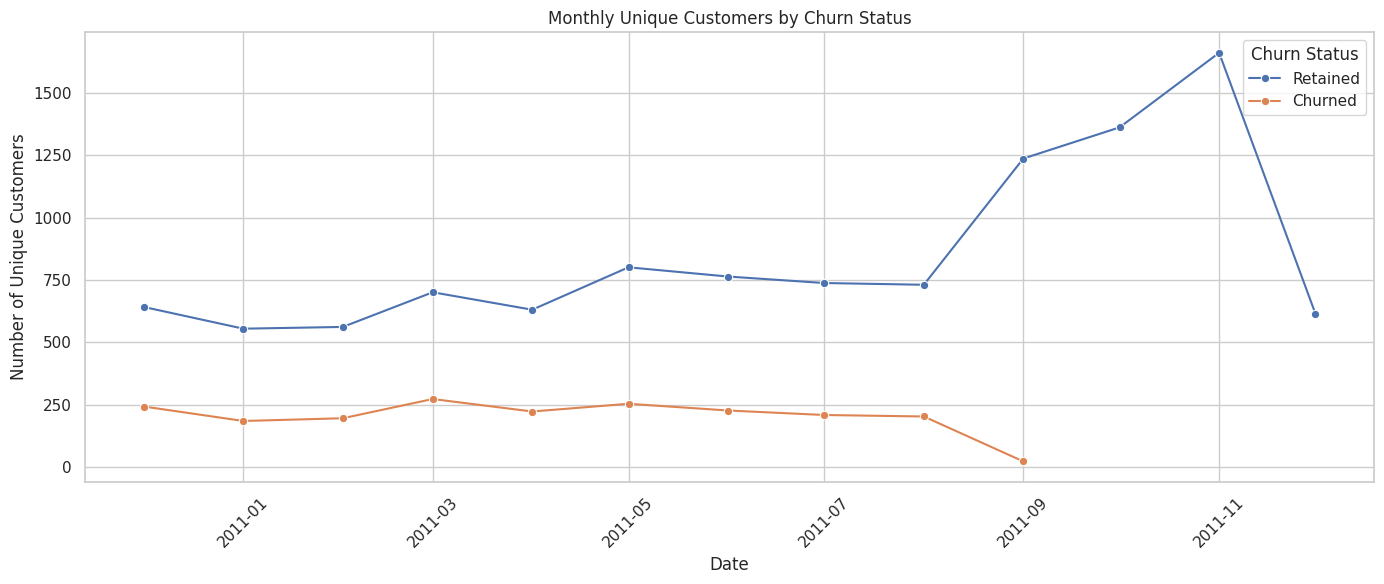

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_churn_pd, x="Date", y="Num_Customers", hue="Churn", marker="o")

plt.title("Monthly Unique Customers by Churn Status")
plt.xlabel("Date")
plt.ylabel("Number of Unique Customers")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Churn Status")
plt.tight_layout()
plt.show()


### Retained Vs Churn Rate Over Time
- Retained customers suddenly dropped deeply after 11/2011, just nearly 1/3 of 11/2011-> Needed to run further analysis on this
- Churned customers suddenly decrease to 0 in 09/2011-> why?

### Monthly Revenue by Churn

In [76]:
from pyspark.sql.functions import col, sum as _sum

monthly_revenue_df = final_df.withColumn("Year", year("InvoiceDate")) \
    .withColumn("Month", month("InvoiceDate")) \
    .withColumn("Revenue", col("Quantity") * col("UnitPrice")) \
    .groupBy("Year", "Month", "Churn") \
    .agg(_sum("Revenue").alias("Total_Revenue")) \
    .orderBy("Year", "Month", "Churn")

monthly_revenue_df.show()


+----+-----+-----+------------------+
|Year|Month|Churn|     Total_Revenue|
+----+-----+-----+------------------+
|2010|   12|    0| 692206.2299999649|
|2010|   12|    1| 83434.68000000033|
|2011|    1|    0| 507437.9500000053|
|2011|    1|    1|162942.28999999954|
|2011|    2|    0|  440877.610000005|
|2011|    2|    1|  66922.2600000002|
|2011|    3|    0| 598501.3900000063|
|2011|    3|    1| 91332.12000000029|
|2011|    4|    0| 419648.1810000029|
|2011|    4|    1| 95729.81000000006|
|2011|    5|    0| 642772.0400000144|
|2011|    5|    1| 97180.96000000027|
|2011|    6|    0| 631824.9500000088|
|2011|    6|    1|105734.03000000003|
|2011|    7|    0| 612481.8010000159|
|2011|    7|    1| 75737.54000000011|
|2011|    8|    0| 653958.8600000086|
|2011|    8|    1| 70257.64000000009|
|2011|    9|    0|1021674.5610000177|
|2011|    9|    1| 6645.820000000005|
+----+-----+-----+------------------+
only showing top 20 rows



In [82]:
monthly_revenue_pd = monthly_revenue_df.toPandas()

In [83]:
monthly_revenue_pd["Month"] = monthly_revenue_pd["Month"].astype(str).str.zfill(2)
monthly_revenue_pd["Date"] = pd.to_datetime(monthly_revenue_pd["Year"].astype(str) + "-" + monthly_revenue_pd["Month"])

In [84]:
monthly_revenue_pd["Churn"] = monthly_revenue_pd["Churn"].map({0: "Retained", 1: "Churned"})

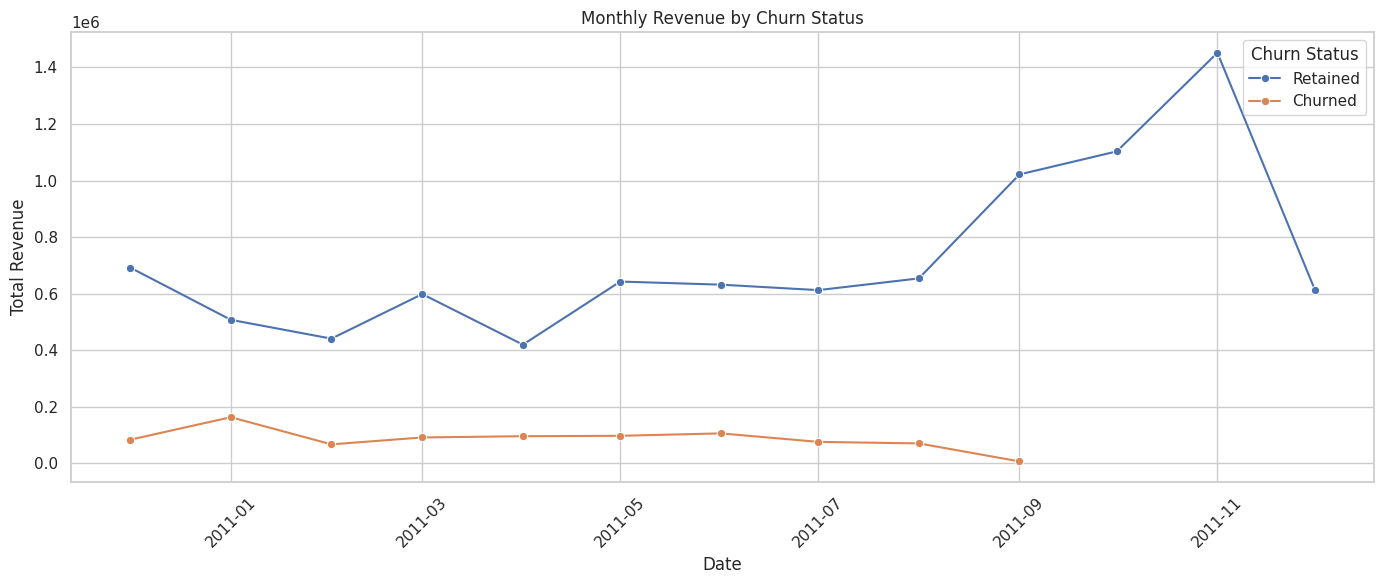

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_revenue_pd, x="Date", y="Total_Revenue", hue="Churn", marker="o")

plt.title("Monthly Revenue by Churn Status")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Churn Status")
plt.tight_layout()
plt.show()


### Monthly Revenue By Churn Status
- Retained customers sales increase steadily from 09 to 11/2011, then suddenly dropped, and then the retained customer rate also dropped -> It might be because of a after-holiday effect, in which customers bulk buying within a short span of time, then left. Maybe because a special promo campaign
- Retained customers prefer to shop in mid-year to end-year season, and has the 1-month off purhcasing behavior-> this is maybe because of a promo, or a seasonal issue
- Churn customers don't buy anything at all in 9/2011, but churn rate dropped to 0 in the same period of time-> suspicious

### What Product/ Category Churn Customer Usually Buy?

In [61]:
final_df.groupBy("Description", "Churn") \
    .agg(count("*").alias("Num_Transactions")) \
    .orderBy(desc("Num_Transactions")) \
    .show(20)


+--------------------+-----+----------------+
|         Description|Churn|Num_Transactions|
+--------------------+-----+----------------+
|WHITE HANGING HEA...|    0|            2046|
|JUMBO BAG RED RET...|    0|            1996|
|REGENCY CAKESTAND...|    0|            1768|
|       PARTY BUNTING|    0|            1507|
|LUNCH BAG RED RET...|    0|            1479|
|ASSORTED COLOUR B...|    0|            1308|
|SET OF 3 CAKE TIN...|    0|            1250|
|LUNCH BAG  BLACK ...|    0|            1228|
|PACK OF 72 RETROS...|    0|            1227|
|JUMBO BAG PINK PO...|    0|            1168|
|JUMBO STORAGE BAG...|    0|            1144|
|PAPER CHAIN KIT 5...|    0|            1142|
|JUMBO SHOPPER VIN...|    0|            1127|
|NATURAL SLATE HEA...|    0|            1126|
|HEART OF WICKER S...|    0|            1109|
|LUNCH BAG SPACEBO...|    0|            1082|
|      SPOTTY BUNTING|    0|            1071|
| LUNCH BAG CARS BLUE|    0|            1071|
|JAM MAKING SET PR...|    0|      

### Churn Pattern By Nations

In [72]:
final_df.groupBy("Country", "Churn") \
    .agg(countDistinct("CustomerID").alias("Num_Customers")) \
    .orderBy(desc("Num_Customers")) \
    .show(30)


+---------------+-----+-------------+
|        Country|Churn|Num_Customers|
+---------------+-----+-------------+
| United Kingdom|    0|         2706|
| United Kingdom|    1|         1211|
|        Germany|    0|           72|
|         France|    0|           64|
|         France|    1|           24|
|          Spain|    0|           23|
|        Germany|    1|           22|
|        Belgium|    0|           18|
|    Switzerland|    0|           15|
|       Portugal|    0|           13|
|        Finland|    0|           10|
|          Italy|    0|           10|
|        Denmark|    0|            9|
|         Norway|    0|            8|
|    Switzerland|    1|            7|
|          Spain|    1|            7|
|        Belgium|    1|            7|
|       Portugal|    1|            7|
|      Australia|    0|            7|
|        Austria|    0|            6|
|         Cyprus|    0|            6|
|    Netherlands|    0|            6|
|         Sweden|    0|            5|
|        Aus

In [73]:
country_churn_df = final_df.groupBy("Country", "Churn") \
    .agg(countDistinct("CustomerID").alias("Num_Customers")) \
    .orderBy(desc("Num_Customers")) \
    .toPandas()


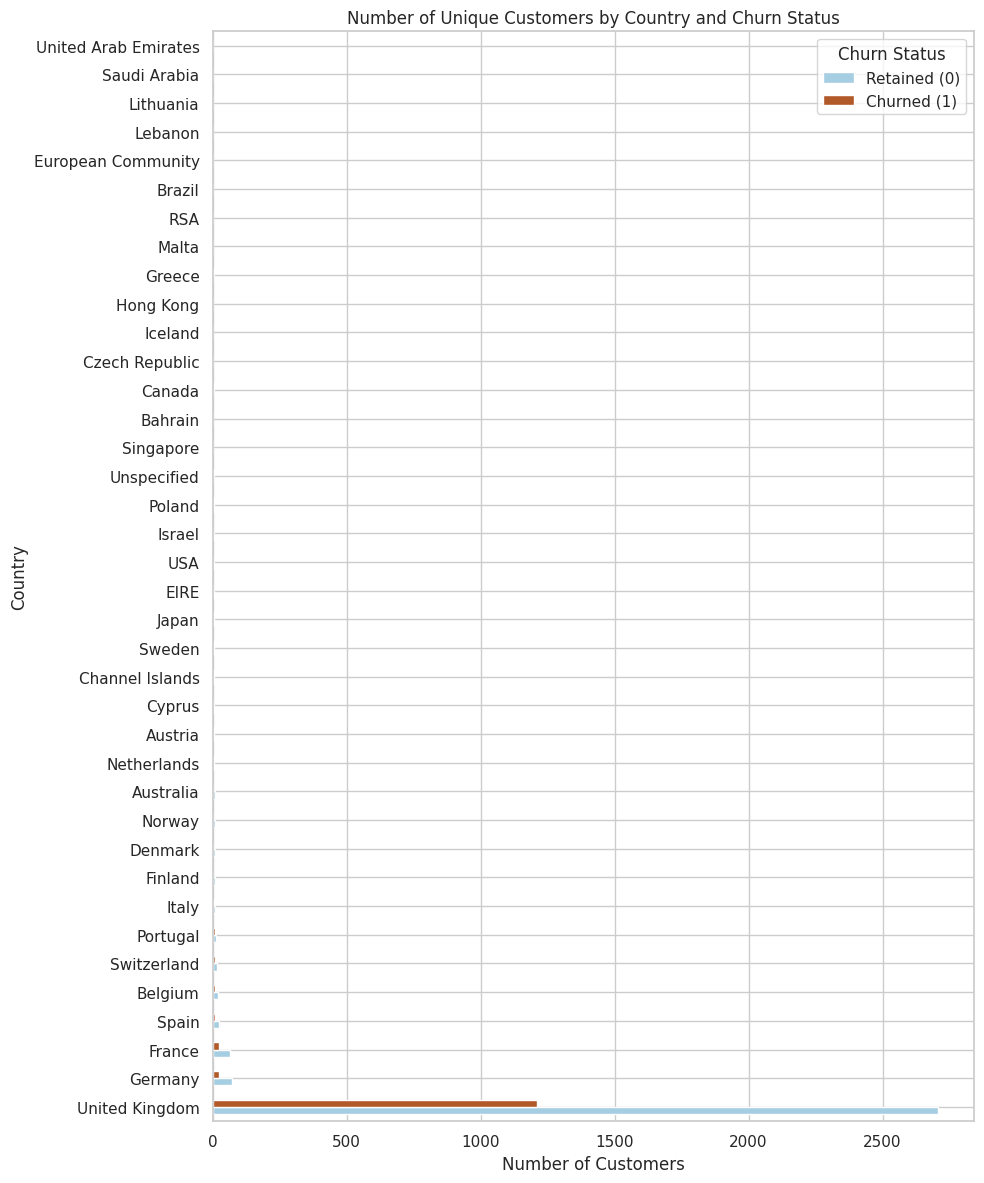

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pivot_df = country_churn_df.pivot(index="Country", columns="Churn", values="Num_Customers").fillna(0)
pivot_df.columns = ['Retained (0)', 'Churned (1)']
pivot_df = pivot_df.sort_values(by='Retained (0)', ascending=False)  # Sort by retained

# Plot
pivot_df.plot(kind='barh', stacked=False, figsize=(10, 12), colormap='Paired')
plt.title("Number of Unique Customers by Country and Churn Status")
plt.xlabel("Number of Customers")
plt.ylabel("Country")
plt.legend(title="Churn Status")
plt.tight_layout()
plt.show()


### Churn By Country
- Mostly in United Kingdom, Germany, France, Spain, with United King Dom has nearly 40% churn rate

### Order Return By Churn Customer

In [63]:
final_df.withColumn("IsReturn", (col("Quantity") < 0).cast("int")) \
    .groupBy("Churn") \
    .agg(
        sum("IsReturn").alias("Num_Returns"),
        count("*").alias("Total_Tx"),
        (sum("IsReturn") / count("*")).alias("Return_Rate")
    ).show()


+-----+-----------+--------+-----------+
|Churn|Num_Returns|Total_Tx|Return_Rate|
+-----+-----------+--------+-----------+
|    1|          0|   35735|        0.0|
|    0|          0|  486806|        0.0|
+-----+-----------+--------+-----------+



### Churn By Order Return Rate
- Orders are not returned by both churn/ non-churn, so probably there is not a problem with product's quality

### Further Analysis With AOV:


In [64]:
from pyspark.sql.functions import col, sum, countDistinct

# Tạo cột doanh thu của mỗi dòng giao dịch
final_df = final_df.withColumn("Revenue", col("Quantity") * col("UnitPrice"))

# Tính AOV theo CustomerID
aov_df = final_df.groupBy("CustomerID").agg(
    sum("Revenue").alias("TotalRevenue"),
    countDistinct("InvoiceNo").alias("NumOrders")
).withColumn("AOV", col("TotalRevenue") / col("NumOrders"))

# Join AOV vào final_df
final_df = final_df.join(aov_df.select("CustomerID", "AOV"), on="CustomerID", how="left")


### Churn Pattern By AOV

In [65]:
final_df.groupBy("Churn").agg(
    avg("AOV").alias("Avg_AOV"),
    expr("percentile_approx(AOV, 0.5)").alias("Median_AOV"),
    max("AOV").alias("Max_AOV"),
    min("AOV").alias("Min_AOV"),
    countDistinct("CustomerID").alias("Num_Customers")
).show()


+-----+------------------+------------------+--------+-------+-------------+
|Churn|           Avg_AOV|        Median_AOV| Max_AOV|Min_AOV|Num_Customers|
+-----+------------------+------------------+--------+-------+-------------+
|    1|402.11266919997536|            305.94| 77183.6|   3.75|         1340|
|    0| 704.3130837721731|488.92333333333335|84236.25|    5.9|         2995|
+-----+------------------+------------------+--------+-------+-------------+



### Churn Pattern By AOV:
- Customer who are not churn, has approximately 2 times higher AOV (Average Order Value) than churn customers,  with the maximum AOV 10 times higher than churn customers -> Premium-tier customers usually stay longer-> filter high-value customers and target them with personalized promotions
